In [3]:
# %pip install pandas numpy matplotlib pyarrow fastparquet  # (uncomment if needed)

import os, re, glob
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 60)

In [4]:
# === PATHS ===
ACTUALS_CSV = "/home/renga/Desktop/data_neoen/data/measurements_neoen_morcenx_sep2025.csv"   # put full path if not in CWD
FORECAST_DIR = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")

# === FORECAST FILE NAMING ===
# Example: forecast_202510070515.csv  -> run time = 2025-10-07 05:15 UTC
FC_PATTERN = "forecast_*.csv"
FC_TS_REGEX = re.compile(r"forecast_(\d{12})\.csv")  # captures YYYYMMDDHHMM

# === COLUMN NAMES ===
ACTUALS_TIME_COL = "measure_date"
ACTUALS_PROD_COL = "prod"  # we're focusing on production

FC_TARGET_COL = "horizon"      # tz-aware UTC timestamps like '2025-07-07 14:15:00+00:00'
FC_DET_COL    = "deterministic"
FC_CLEAR_SKY  = "clear_sky"

# Quantiles we’ll read from forecast files
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
]

# Convenience subsets
FC_P10_COL, FC_P50_COL, FC_P90_COL = "p_10", "p_50", "p_90"

# Analysis window for actuals (optional, speeds things up). Use UTC date strings.
DATE_MIN = None  # e.g., "2025-09-01"
DATE_MAX = None  # e.g., "2025-09-30"


In [5]:
# Helper: turn a user selection (e.g., 10 or [5, 10, 50, 90]) into valid column names.
def normalize_p_selection(p_selection):
    """
    Accepts: int/float (e.g., 10), str ('p_10' or '10'), or list/tuple of those.
    Returns: (col_names, pretty_labels) where:
      col_names like ['p_10','p_50'], pretty_labels like ['p10','p50']
    """
    if p_selection is None:
        return [], []

    def to_col(x):
        if isinstance(x, (int, float)):
            v = int(round(x))
            return f"p_{v:02d}"
        s = str(x).strip().lower()
        if s.startswith("p_"):
            return s
        # '10' -> 'p_10'
        return f"p_{int(round(float(s))):02d}"

    if isinstance(p_selection, (list, tuple, set)):
        cols = [to_col(v) for v in p_selection]
    else:
        cols = [to_col(p_selection)]

    # de-dup while preserving order and keep only those that actually exist in your files config
    seen, cols_ok = set(), []
    for c in cols:
        if c in seen: 
            continue
        if c not in FC_QUANT_COLS:
            print(f"[warn] Requested quantile '{c}' not in available columns; skipping.")
            continue
        seen.add(c)
        cols_ok.append(c)

    labels = [c.replace("p_", "p") for c in cols_ok]  # 'p_10' -> 'p10'
    return cols_ok, labels


In [6]:
actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACTUALS_TIME_COL])

# Ensure tz-aware UTC (your sample already is, but this keeps it robust)
if actuals[ACTUALS_TIME_COL].dtype.tz is None:
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_localize("UTC")
else:
    # Normalize to UTC in case it’s another tz (unlikely given +00:00)
    actuals[ACTUALS_TIME_COL] = actuals[ACTUALS_TIME_COL].dt.tz_convert("UTC")

# Optional date window
if DATE_MIN:
    actuals = actuals[actuals[ACTUALS_TIME_COL] >= pd.to_datetime(DATE_MIN, utc=True)]
if DATE_MAX:
    actuals = actuals[actuals[ACTUALS_TIME_COL] <= pd.to_datetime(DATE_MAX, utc=True)]

# --- Keep only exact 15-minute grid points (…:00, :15, :30, :45) ---
# This is a strict filter (no averaging), matching your forecast cadence.
mask_15 = (
    (actuals[ACTUALS_TIME_COL].dt.minute % 15 == 0) &
    (actuals[ACTUALS_TIME_COL].dt.second == 0) &
    (actuals[ACTUALS_TIME_COL].dt.microsecond == 0)
)
actuals_15 = actuals.loc[mask_15].copy()

# Keep only time + prod (adjust if you need more columns later)
actuals_15 = actuals_15[[ACTUALS_TIME_COL, ACTUALS_PROD_COL]].sort_values(ACTUALS_TIME_COL).reset_index(drop=True)

display(actuals_15.head(8))
# print("Actual rows at 15-min cadence:", len(actuals_15))


,measure_date,prod
0,2025-09-01 00:00:00+00:00,0.0
1,2025-09-01 00:15:00+00:00,0.0
2,2025-09-01 00:30:00+00:00,0.0
3,2025-09-01 00:45:00+00:00,0.0
4,2025-09-01 01:00:00+00:00,0.0
5,2025-09-01 01:15:00+00:00,0.0
6,2025-09-01 01:30:00+00:00,0.0
7,2025-09-01 01:45:00+00:00,0.0


In [7]:
def run_time_to_filename(run_ts_utc: pd.Timestamp) -> Path:
    """Make forecast filename from a UTC run timestamp (rounded to 15 min)."""
    if run_ts_utc.tz is None:
        run_ts_utc = run_ts_utc.tz_localize("UTC")
    ts_str = run_ts_utc.strftime("%Y%m%d%H%M")  # YYYYMMDDHHMM
    return FORECAST_DIR / f"forecast_{ts_str}.csv"

def filename_to_run_time(path: Path) -> pd.Timestamp:
    m = FC_TS_REGEX.match(path.name)
    if not m:
        raise ValueError(f"Unexpected forecast filename: {path.name}")
    ts = datetime.strptime(m.group(1), "%Y%m%d%H%M")
    return pd.Timestamp(ts, tz="UTC")

def safe_read_forecast(path: Path, usecols=None) -> pd.DataFrame | None:
    """Read a forecast CSV, or return None if missing/empty/bad."""
    if not path.exists():
        return None
    try:
        df = pd.read_csv(path, parse_dates=[FC_TARGET_COL], usecols=usecols)
        # Ensure target is tz-aware UTC; if not, localize (adjust if they’re local)
        if df[FC_TARGET_COL].dtype.tz is None:
            df[FC_TARGET_COL] = df[FC_TARGET_COL].dt.tz_localize("UTC")
        return df
    except Exception as e:
        print(f"Warning: skipping {path.name}: {e}")
        return None


In [8]:
def collect_forecasts_for_target(target_ts_utc: pd.Timestamp) -> pd.DataFrame:
    """
    For a given target timestamp (UTC), fetch the predictions for that target
    from all run files whose forecast horizon includes the target (last 48h).
    Returns a tidy DataFrame: one row per run_time with deterministic, clear_sky, quantiles, and lead_hours.
    """
    if target_ts_utc.tz is None:
        target_ts_utc = target_ts_utc.tz_localize("UTC")

    run_start = target_ts_utc - pd.Timedelta(hours=48)
    run_times = pd.date_range(run_start, target_ts_utc, freq="15min", tz="UTC")

    rows = []
    usecols = [FC_TARGET_COL, FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS

    for run_ts in run_times:
        path = run_time_to_filename(run_ts)
        df = safe_read_forecast(path, usecols=usecols)
        if df is None or df.empty:
            continue

        # Extract the row where horizon equals our target time
        # (exact match; if your CSV timestamps differ in rounding, consider a tolerance)
        matched = df.loc[df[FC_TARGET_COL] == target_ts_utc]
        if matched.empty:
            continue

        row = matched.iloc[0].to_dict()
        row["run_time"] = run_ts
        row["target_time"] = target_ts_utc
        row["lead_hours"] = (target_ts_utc - run_ts).total_seconds() / 3600.0
        rows.append(row)

    if not rows:
        return pd.DataFrame(columns=["run_time","target_time","lead_hours", FC_DET_COL, FC_CLEAR_SKY] + FC_QUANT_COLS)

    out = pd.DataFrame(rows).sort_values("run_time").reset_index(drop=True)
    return out


In [12]:
# Manually set your target timestamp (must exist in actuals_15) ---

# Example: paste the exact timestamp from your data (UTC, tz-aware).
TARGET_TS_STR = "2025-09-10 16:45:00+00:00"  # <- change this

TARGET_TS = pd.to_datetime(TARGET_TS_STR, utc=True)

# Validate it exists in actuals_15
if not (actuals_15[ACTUALS_TIME_COL] == TARGET_TS).any():
    # Show a hint of nearby options if not found
    print(f"[Warning] {TARGET_TS} not found in actuals_15.")
    # Suggest the closest available timestamp
    diffs = (actuals_15[ACTUALS_TIME_COL] - TARGET_TS).abs()
    closest_idx = diffs.argmin()
    print("Closest available:", actuals_15.loc[closest_idx, ACTUALS_TIME_COL])

print("Target timestamp:", TARGET_TS)

fc_target = collect_forecasts_for_target(TARGET_TS)
display(fc_target.head(172))
print("Forecast runs found:", len(fc_target), "(expected up to 192 if all files exist)")


Target timestamp: 2025-09-10 16:45:00+00:00


,horizon,p_05,p_10,p_15,p_20,p_25,p_30,p_35,p_40,p_45,p_50,p_55,p_60,p_65,p_70,p_75,p_80,p_85,p_90,p_95,clear_sky,deterministic,run_time,target_time,lead_hours
0,2025-09-10 16:45:00+00:00,19.740170,69.421824,143.304533,196.292015,308.397536,468.391322,597.333563,734.938962,876.059489,1013.627991,1212.321444,1400.543485,1658.721695,1785.620651,1936.168876,2319.465699,3373.513847,5165.432132,6349.464609,7211.141078,1281.944378,2025-09-08 16:45:00+00:00,2025-09-10 16:45:00+00:00,48.00
1,2025-09-10 16:45:00+00:00,28.331829,90.664530,156.034192,223.333271,316.156180,477.310302,645.460169,734.682597,905.481645,1066.938315,1295.176224,1495.506708,1702.022787,1824.552782,1984.753185,2453.903535,3427.347287,5240.017611,6448.355490,7201.409202,1320.477209,2025-09-08 17:00:00+00:00,2025-09-10 16:45:00+00:00,47.75
2,2025-09-10 16:45:00+00:00,33.688955,102.426819,169.416462,237.521705,337.925517,523.178138,683.890454,750.829862,894.017056,1055.884064,1262.505180,1472.916077,1732.521542,1823.383120,1962.921826,2478.644955,3836.293793,5405.223259,7119.414604,7201.409202,1372.561380,2025-09-08 17:15:00+00:00,2025-09-10 16:45:00+00:00,47.50
3,2025-09-10 16:45:00+00:00,7.701033,103.952330,152.288164,237.495466,361.233666,525.823821,640.717834,760.921107,894.589620,1056.415345,1216.294525,1372.457016,1638.400728,1747.217424,1874.849256,2504.088693,3710.617811,5511.421173,6657.643970,7201.409202,1319.316190,2025-09-08 17:30:00+00:00,2025-09-10 16:45:00+00:00,47.25
4,2025-09-10 16:45:00+00:00,20.893994,137.522302,197.279299,282.179175,410.880549,596.924587,760.126377,856.731511,991.721983,1170.626086,1307.230676,1438.054557,1730.455099,1842.470463,2033.634815,3337.929636,4286.872046,5621.949683,6892.557332,7201.409202,1440.662620,2025-09-08 17:45:00+00:00,2025-09-10 16:45:00+00:00,47.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2025-09-10 16:45:00+00:00,293.585993,437.188195,592.361989,756.779928,862.749890,1005.817952,1169.475540,1309.411907,1454.142982,1637.909740,1743.682456,1848.925173,1987.834740,2380.095833,2876.126672,3644.282152,4423.984715,5676.197537,8614.603938,7195.449428,1933.755041,2025-09-10 15:15:00+00:00,2025-09-10 16:45:00+00:00,1.50
168,2025-09-10 16:45:00+00:00,874.391907,1070.931477,1275.668330,1544.338071,1734.067715,1940.256714,2310.438288,2590.732107,2954.468769,3275.790535,3826.564793,4142.390912,4617.665626,5380.356579,5882.242895,6720.784190,7412.160474,7781.799080,8585.762675,7195.449428,3621.246768,2025-09-10 15:30:00+00:00,2025-09-10 16:45:00+00:00,1.25
169,2025-09-10 16:45:00+00:00,995.397150,1230.167830,1403.669901,1542.084264,1719.689399,1907.912177,2062.005777,2372.777810,2539.467548,2872.527265,3167.061397,3659.611051,4020.012513,4391.315427,5085.221323,5588.693092,6309.671572,7852.448705,8651.687195,7195.449428,3247.432894,2025-09-10 15:45:00+00:00,2025-09-10 16:45:00+00:00,1.00
170,2025-09-10 16:45:00+00:00,1035.400664,1232.309400,1325.821635,1404.148338,1532.064800,1595.782215,1659.455270,1742.031524,1895.539868,2053.868553,2304.912829,2628.004844,2898.378731,3151.897859,3793.845479,4295.212838,4976.606828,5611.132489,8187.936153,7195.449428,2659.151066,2025-09-10 16:00:00+00:00,2025-09-10 16:45:00+00:00,0.75


Forecast runs found: 172 (expected up to 192 if all files exist)


In [13]:
# Configurable errors per run + MAE/RMSE summaries

# === User selection ===
INCLUDE_DET = True           # compare deterministic?
INCLUDE_CLEAR_SKY = False    # compare clear_sky as well?
P_SELECTION = [30,40,50,60,70]   # choose any single value (e.g., 35) or list like [5,10,20,50,80,90]

# Build the list of forecast columns to evaluate
p_cols, p_labels = normalize_p_selection(P_SELECTION)

forecast_cols = []
labels_map = {}   # column_name -> pretty label for plots/tables

if INCLUDE_DET:
    forecast_cols.append(FC_DET_COL); labels_map[FC_DET_COL] = "deterministic"
if INCLUDE_CLEAR_SKY:
    forecast_cols.append(FC_CLEAR_SKY); labels_map[FC_CLEAR_SKY] = "clear_sky"

for c, lab in zip(p_cols, p_labels):
    forecast_cols.append(c); labels_map[c] = lab

# 1) Actual value
actual_val = float(actuals_15.loc[actuals_15[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0])
print("Target timestamp:", TARGET_TS)
print("Actual prod at target:", actual_val)
print("Comparing forecast series:", [labels_map[c] for c in forecast_cols])

# 2) Long/tidy per-run table
err_long = (
    fc_target[["run_time", "lead_hours"] + forecast_cols]
      .melt(id_vars=["run_time","lead_hours"], var_name="forecast_col", value_name="forecast_value")
      .sort_values(["forecast_col","run_time"])
      .reset_index(drop=True)
)

# 3) Add errors
err_long["error"] = err_long["forecast_value"] - actual_val
err_long["abs_error"] = err_long["error"].abs()
err_long["squared_error"] = err_long["error"]**2
err_long["forecast_type"] = err_long["forecast_col"].map(labels_map)

print("\nPer-run errors (head):")
display(err_long.head(12))

# 4) Summaries by forecast type
summary_by_type = (
    err_long.groupby("forecast_type", as_index=False)
            .agg(n_runs=("error","size"),
                 MAE=("abs_error","mean"),
                 RMSE=("squared_error", lambda s: (s.mean())**0.5),
                 Bias=("error","mean"))
            .sort_values("MAE")
)
print("\nSummary metrics across runs for this target:")
display(summary_by_type)

# 5) Optional: by lead time
err_long["lead_hr_bin"] = err_long["lead_hours"].round(0)
summary_by_lead = (
    err_long.groupby(["forecast_type","lead_hr_bin"], as_index=False)
            .agg(n=("error","size"),
                 MAE=("abs_error","mean"),
                 RMSE=("squared_error", lambda s: (s.mean())**0.5),
                 Bias=("error","mean"))
            .sort_values(["forecast_type","lead_hr_bin"])
)
print("\nMAE/RMSE vs lead time (per type):")
display(summary_by_lead.head(192))


Target timestamp: 2025-09-10 16:45:00+00:00
Actual prod at target: 3507.0981
Comparing forecast series: ['deterministic', 'p30', 'p40', 'p50', 'p60', 'p70']

Per-run errors (head):


,run_time,lead_hours,forecast_col,forecast_value,error,abs_error,squared_error,forecast_type
0,2025-09-08 16:45:00+00:00,48.00,deterministic,1281.944378,-2225.153722,2225.153722,4.951309e+06,deterministic
1,2025-09-08 17:00:00+00:00,47.75,deterministic,1320.477209,-2186.620891,2186.620891,4.781311e+06,deterministic
2,2025-09-08 17:15:00+00:00,47.50,deterministic,1372.561380,-2134.536720,2134.536720,4.556247e+06,deterministic
3,2025-09-08 17:30:00+00:00,47.25,deterministic,1319.316190,-2187.781910,2187.781910,4.786390e+06,deterministic
4,2025-09-08 17:45:00+00:00,47.00,deterministic,1440.662620,-2066.435480,2066.435480,4.270156e+06,deterministic
5,2025-09-08 18:00:00+00:00,46.75,deterministic,1470.360446,-2036.737654,2036.737654,4.148300e+06,deterministic
6,2025-09-08 18:15:00+00:00,46.50,deterministic,1536.523467,-1970.574633,1970.574633,3.883164e+06,deterministic
7,2025-09-08 18:30:00+00:00,46.25,deterministic,1521.749536,-1985.348564,1985.348564,3.941609e+06,deterministic
8,2025-09-08 18:45:00+00:00,46.00,deterministic,1553.407386,-1953.690714,1953.690714,3.816907e+06,deterministic
9,2025-09-08 19:00:00+00:00,45.75,deterministic,1545.154228,-1961.943872,1961.943872,3.849224e+06,deterministic



Summary metrics across runs for this target:


,forecast_type,n_runs,MAE,RMSE,Bias
5,p70,172,1312.053548,1425.127027,-1245.438794
0,deterministic,172,1696.239417,1754.341432,-1685.802379
4,p60,172,1789.726288,1843.370994,-1764.752887
3,p50,172,2113.868012,2148.052284,-2104.723992
2,p40,172,2359.010247,2386.271592,-2354.902830
1,p30,172,2602.397703,2626.286655,-2602.397703



MAE/RMSE vs lead time (per type):


,forecast_type,lead_hr_bin,n,MAE,RMSE,Bias
0,deterministic,0.0,1,783.436550,783.436550,783.436550
1,deterministic,1.0,3,407.253636,516.226730,-331.154524
2,deterministic,2.0,3,1211.486795,1242.408208,-1211.486795
3,deterministic,3.0,2,604.025135,617.539367,-604.025135
4,deterministic,4.0,5,719.163172,740.765559,-719.163172
...,...,...,...,...,...,...
187,p50,40.0,5,2132.047960,2132.280081,-2132.047960
188,p50,41.0,3,2136.147650,2136.309635,-2136.147650
189,p50,42.0,5,2187.118334,2207.805530,-2187.118334
190,p50,43.0,3,2353.017075,2354.151704,-2353.017075


In [20]:
# Cell 6.x — Holistic per-run summary table

# 0) Actual value at target
actual_value = float(
    actuals_15.loc[actuals_15[ACTUALS_TIME_COL] == TARGET_TS, ACTUALS_PROD_COL].iloc[0]
)

# 1) Build tidy table (one row per run_time × forecast series)
cols_needed = ["run_time", "lead_hours"] + forecast_cols
long = (
    fc_target[cols_needed]
      .melt(id_vars=["run_time", "lead_hours"],
            var_name="forecast_col", value_name="forecast_value")
      .sort_values(["lead_hours", "forecast_col"], ascending=[False, True])
      .reset_index(drop=True)
)

# 2) Map to clean names (e.g., p_50 -> p50)
clean_name = long["forecast_col"].map(labels_map)
long["forecast_type"] = clean_name.fillna(long["forecast_col"].str.replace("p_", "p", regex=False))

# 3) Errors vs actual
long["actual_value"]  = actual_value
long["error"]         = long["forecast_value"] - long["actual_value"]
long["abs_error"]     = long["error"].abs()
long["squared_error"] = long["error"] ** 2

# 4) Final summary view with requested columns
per_run_summary = (
    long[["run_time", "lead_hours", "forecast_type",
          "actual_value", "forecast_value", "error", "abs_error", "squared_error"]]
    .sort_values(["lead_hours", "forecast_type"], ascending=[False, True])
    .reset_index(drop=True)
)

print(f"Target: {TARGET_TS}   |   actual_value={actual_value:,.3f}")
print(f"Rows: {len(per_run_summary)}  (≈ number_of_runs × number_of_selected_series)")
per_run_summary = per_run_summary.sort_values("run_time")
display(per_run_summary.tail(48))

# display(per_run_summary.head(1032))

# OPTIONAL: quick overall metrics by forecast_type (keep if useful)
summary_metrics = (
    per_run_summary.groupby("forecast_type", as_index=False)
                   .agg(n=("error","size"),
                        MAE=("abs_error","mean"),
                        RMSE=("squared_error", lambda s: (s.mean())**0.5),
                        Bias=("error","mean"))
                   .sort_values("MAE")
)
display(summary_metrics)

# OPTIONAL: save to CSV for this target
# out_name = f"per_run_summary_{str(TARGET_TS).replace(':','').replace(' ','_')}.csv"
# per_run_summary.to_csv(out_name, index=False)
# print("Saved:", out_name)


Target: 2025-09-10 16:45:00+00:00   |   actual_value=3,507.098
Rows: 1032  (≈ number_of_runs × number_of_selected_series)


,run_time,lead_hours,forecast_type,actual_value,forecast_value,error,abs_error,squared_error
988,2025-09-10 13:45:00+00:00,3.00,p60,3507.0981,2694.859747,-812.238353,812.238353,6.597311e+05
987,2025-09-10 13:45:00+00:00,3.00,p50,3507.0981,2273.361115,-1233.736985,1233.736985,1.522107e+06
989,2025-09-10 13:45:00+00:00,3.00,p70,3507.0981,3255.968828,-251.129272,251.129272,6.306591e+04
985,2025-09-10 13:45:00+00:00,3.00,p30,3507.0981,1563.990016,-1943.108084,1943.108084,3.775669e+06
984,2025-09-10 13:45:00+00:00,3.00,deterministic,3507.0981,2774.587537,-732.510563,732.510563,5.365717e+05
986,2025-09-10 13:45:00+00:00,3.00,p40,3507.0981,1874.802403,-1632.295697,1632.295697,2.664389e+06
990,2025-09-10 14:15:00+00:00,2.50,deterministic,3507.0981,2601.486967,-905.611133,905.611133,8.201315e+05
991,2025-09-10 14:15:00+00:00,2.50,p30,3507.0981,1367.144930,-2139.953170,2139.953170,4.579400e+06
992,2025-09-10 14:15:00+00:00,2.50,p40,3507.0981,1717.255324,-1789.842776,1789.842776,3.203537e+06
993,2025-09-10 14:15:00+00:00,2.50,p50,3507.0981,1934.205736,-1572.892364,1572.892364,2.473990e+06


,forecast_type,n,MAE,RMSE,Bias
5,p70,172,1312.053548,1425.127027,-1245.438794
0,deterministic,172,1696.239417,1754.341432,-1685.802379
4,p60,172,1789.726288,1843.370994,-1764.752887
3,p50,172,2113.868012,2148.052284,-2104.723992
2,p40,172,2359.010247,2386.271592,-2354.902830
1,p30,172,2602.397703,2626.286655,-2602.397703


NameError: name 'df_plot' is not defined

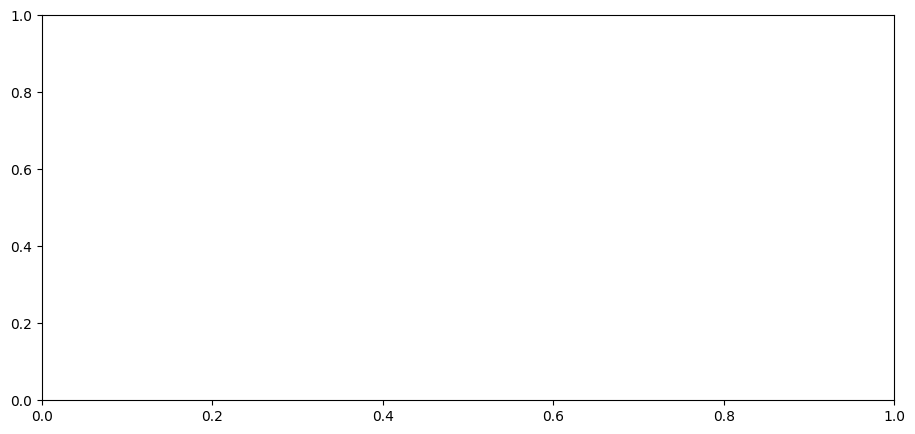

In [21]:
# forecasts vs lead time with clearer highlights & annotations ===
import matplotlib.ticker as mtick

# Choose what to HIGHLIGHT (subset of forecast_cols)
# e.g., highlight det + p50 + p90
HIGHLIGHT_DET = True
HIGHLIGHT_CLEAR_SKY = False
HIGHLIGHT_P = []  # will intersect with what's actually in forecast_cols
hi_p_cols, _ = normalize_p_selection(HIGHLIGHT_P)

highlight_cols = set()
if HIGHLIGHT_DET and ("deterministic" in labels_map.values()):
    highlight_cols.add(FC_DET_COL)
if HIGHLIGHT_CLEAR_SKY and ("clear_sky" in labels_map.values()):
    highlight_cols.add(FC_CLEAR_SKY)
highlight_cols.update(set(hi_p_cols) & set(forecast_cols))

# Vertical markers to emphasize 1h and 15m before target
marker_targets = [1.0, 0.25]   # hours

# ---------- Forecasted value plot ----------
fig, ax = plt.subplots(figsize=(11,5))

# Right gutter so annotations at the near-0 side have room
x_max = float(df_plot["lead_hours"].max())
ax.set_xlim(x_max + 2, -0.5)   # inverted axis + 2h pad on the left, 0.5h pad on the right

# Actual line
ax.axhline(actual_val, linestyle="--", linewidth=1.2, label="Actual")

# Vertical reference lines
for lt in marker_targets:
    ax.axvline(lt, linestyle=":", linewidth=1, alpha=0.7)

# Plot all selected series; highlight chosen ones
for col in forecast_cols:
    label = labels_map[col]
    is_hi = col in highlight_cols
    lw = 2.8 if is_hi else 1.1
    alpha = 1.0 if is_hi else 0.35
    ls = "-" if is_hi else "--"
    ax.plot(df_plot["lead_hours"], df_plot[col], label=label, linewidth=lw, alpha=alpha, linestyle=ls, zorder=3 if is_hi else 2)
    if is_hi:
        ax.scatter(df_plot["lead_hours"], df_plot[col], s=10, alpha=0.6, zorder=4)

# Optional p10–p90 band if both are present (kept faint)
if ("p_10" in forecast_cols) and ("p_90" in forecast_cols):
    ax.fill_between(df_plot["lead_hours"], df_plot["p_10"], df_plot["p_90"], alpha=0.15, label="p10–p90 band", zorder=1)

# Annotations for highlighted series at T−1h and T−15m
for lt in marker_targets:
    row = df_plot.iloc[(df_plot["lead_hours"] - lt).abs().idxmin()]
    for col in highlight_cols:
        y = float(row[col])
        ax.scatter([row["lead_hours"]], [y], s=80, zorder=5)
        ax.annotate(
            f"{labels_map[col]} @ {row['lead_hours']:.2f}h\n{y:.0f}",
            (row["lead_hours"], y),
            textcoords="offset points",
            xytext=(6,6),
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
            zorder=6,
            clip_on=False
        )

ax.set_xlabel("Lead time (hours until target)")
ax.set_ylabel("Forecasted prod at target")
ax.set_title(f"Forecasts for target {TARGET_TS} vs lead time")

# Format y with thousands separators (no units change)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Legend outside to avoid covering lines
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Absolute error plot (mirrors styling) ----------
fig, ax = plt.subplots(figsize=(11,5))
ax.set_xlim(x_max + 2, -0.5)
for lt in marker_targets:
    ax.axvline(lt, linestyle=":", linewidth=1, alpha=0.7)

for col in forecast_cols:
    label = labels_map[col]
    is_hi = col in highlight_cols
    series = (df_plot[col] - actual_val).abs()
    lw = 2.8 if is_hi else 1.1
    alpha = 1.0 if is_hi else 0.35
    ls = "-" if is_hi else "--"
    ax.plot(df_plot["lead_hours"], series, label=f"|{label} − Actual|", linewidth=lw, alpha=alpha, linestyle=ls, zorder=3 if is_hi else 2)
    if is_hi:
        ax.scatter(df_plot["lead_hours"], series, s=10, alpha=0.6, zorder=4)

for lt in marker_targets:
    row = df_plot.iloc[(df_plot["lead_hours"] - lt).abs().idxmin()]
    for col in highlight_cols:
        y = abs(float(row[col]) - actual_val)
        ax.scatter([row["lead_hours"]], [y], s=80, zorder=5)

ax.set_xlabel("Lead time (hours until target)")
ax.set_ylabel("Absolute error")
ax.set_title(f"Absolute error at target {TARGET_TS} vs lead time")
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()
